In [48]:
import pandas as pd
import numpy as np

# read red wine set of observations
data_red = pd.read_csv("C:/Users/ag4488/Documents/Python/svm-classification-with-pytorch/data/winequality-red.csv",sep=',')
data_red['color'] = 1 #redwine

print(data_red.shape)

# read white wine set of observations
data_white = pd.read_csv("C:/Users/ag4488/Documents/Python/svm-classification-with-pytorch/data/winequality-white.csv",sep=',')
data_white['color'] = 0 #whitewine

print(data_white.shape)

# merge the two sets in one
data = data_red.merge(data_white, how='outer')
fields = list(data.columns)
print(fields)

(1599, 13)
(4898, 13)
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


In [49]:
# show the counts of all quality levels
print("All 'quality level' counts")
print(data["quality"].value_counts())

All 'quality level' counts
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


In [50]:
# based on the "quality histograms" above, we will drop the ratings with low counts (we will keep only 5,6,7)
data = data.drop(data[data.quality == 9].index)
data = data.drop(data[data.quality == 8].index)
data = data.drop(data[data.quality == 3].index)
data = data.drop(data[data.quality == 4].index)

# show the counts of selected quality levels
print("Selected 'quality level' counts")
print(data["quality"].value_counts())

Selected 'quality level' counts
6    2836
5    2138
7    1079
Name: quality, dtype: int64


In [51]:
# split the data set in two: 1) color+features (observations)  2) quality (actuals)

# select the outcomes
y = data['quality']

data = data.drop(columns=['quality'])

# select the rows (observations)
fields = list(data.columns)
X = data[fields]
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


A Pearson correlation was used to identify which features correlate with wine quality. It looks as if higher the alcohol content the higher the quality. Lower density and volatile acidity also correlated with better quality as seen in the pairwise correlation chart the chart below. Only the top 5 correlated features were carried over to the SVM models.

In [52]:
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)

# the following fields are the 5 retained as having the highest correlations to wine quality
fields = correlations.map(abs).sort_values().iloc[-5:].index
print(fields) #prints the top two abs correlations

Index(['color', 'chlorides', 'volatile acidity', 'density', 'alcohol'], dtype='object')


[(-1, 1), Text(0, 0.5, 'pearson correlation')]

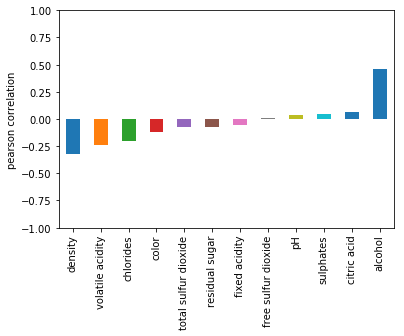

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# The figure below shows Pearson Pairwise correlation of features to wine quality.
# Looks like alcohol and density are the most correlated with quality
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')

We will run now K_Nearest Neighbour algorithm (KNN) to create a "prediction model"
KNN converges faster when features are scaled. If the model is senstive to magnitudes its generally a good idea to scale so one feature doesn’t get more influence than the other(in terms of scale).

In [54]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

DO_STANDARDSCALER = True
X = data[fields]
scaler = None

if DO_STANDARDSCALER:
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
    print(X.columns) #scaled columns

    print(scaler.mean_)
    print(scaler.scale_)

else:
    scaler = MinMaxScaler().fit(X)
    print(scaler.data_max_)
    print(scaler.data_min_)

    X = scaler.transform(X)

    X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
    print(X.columns) #scaled columns

Index(['color_scaled', 'chlorides_scaled', 'volatile acidity_scaled',
       'density_scaled', 'alcohol_scaled'],
      dtype='object')
[ 0.25078473  0.05628531  0.3361515   0.99475887 10.46505534]
[0.43346482 0.03466447 0.15956969 0.00299232 1.17553508]


In [55]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# we will split the data in training (70%) and testing (30%) whihc is the usual ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNN learning model (k=15)
knn = KNeighborsClassifier(n_neighbors=15)
# predict the wine rankings for the test data set

# Fit the model
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

print(print('predict\tactual\tcolor_scaled,','chlorides_scaled,','volatile acidity_scaled,','density_scaled,','alcohol_scaled'))
i=0
for index,row in X_test.iterrows():
    print(f"{list(y_pred)[i]}\t{list(y_test)[i]}\t",f"{row['color_scaled']}, {row['chlorides_scaled']},{row['volatile acidity_scaled']}, {row['density_scaled']},{row['alcohol_scaled']}")
    i=i+1

predict	actual	color_scaled, chlorides_scaled, volatile acidity_scaled, density_scaled, alcohol_scaled
None
7	7	 -0.578558448837331, -0.5274943341065409,-0.03855052419905302, -1.1124699629500565,2.496688285657557
6	5	 1.7284338376003265, 0.3956410056455444,0.5881349141704033, 1.8851991168784459,-1.246288072055706
7	6	 -0.578558448837331, -0.2967104991685196,-0.9785786817532378, -0.15334953272621177,0.6252001068009249
6	5	 -0.578558448837331, -0.3255584785357723,-0.28922469954683583, 0.8157965465940408,-0.8209498495882898
5	5	 1.7284338376003265, 1.693800077171914,2.0295114224201534, 0.5116851906694225,-0.14040869364042316
6	7	 -0.578558448837331, -0.7005822103100567,0.024118019637892684, -1.0356066532108432,1.5609441962292419
5	6	 1.7284338376003265, 0.48218494374730203,0.27479219498567514, 0.6988306404691962,-0.8209498495882898
6	6	 1.7284338376003265, 0.42448898501279664,0.9641461771920772, -0.29370862007603277,1.3057412627487914
6	5	 -0.578558448837331, 2.357303602618725,-1.10391576

5	5	 1.7284338376003265, 0.5687288818490601,2.4681912292787724, 0.8157965465940408,-0.9910851385752556
5	5	 1.7284338376003265, 1.9534318914771875,2.21751705393099, 1.6512673046287567,-0.2254763381339076
6	6	 -0.578558448837331, -0.7582781690445621,-0.8532415940793464, -0.5209566662614749,-0.2254763381339076
6	6	 -0.578558448837331, -0.037078684863245656,-1.2292528571010204, -0.0865118720834063,-0.7358822050948067
6	6	 -0.578558448837331, -0.23901454043401424,-0.3518932433837812, 0.8826342072368092,-0.3105439826273905
5	6	 -0.578558448837331, -0.09477464359775102,-1.4172584886118573, 0.6687536931799727,-0.5657469161078393
5	5	 -0.578558448837331, -0.4121024166375301,-0.16388761187294443, 0.013744618880746249,-0.5657469161078393
5	6	 -0.578558448837331, -0.12362262296500351,0.024118019637892684, 1.216822510450688,-0.9910851385752556
6	6	 -0.578558448837331, -0.6140382722082987,-0.9785786817532378, -0.6880508178683957,0.029726595346542737
6	6	 -0.578558448837331, -0.21016656106676154,-0.

7	7	 -0.578558448837331, -0.2967104991685196,0.40012928265956654, -1.510154043774543,1.3057412627487914
6	6	 -0.578558448837331, -0.7582781690445621,-1.3545899447749117, -0.835093671282501,1.3908089072422745
5	7	 -0.578558448837331, -0.7005822103100567,-0.22655615570989013, 1.183403680129304,-0.9910851385752556
6	7	 -0.578558448837331, -0.931366045248078,0.024118019637892684, -1.3898462546175379,1.4758765517357573
6	7	 -0.578558448837331, -0.6140382722082987,-0.28922469954683583, -1.4132394358425513,0.7953353957878923
6	7	 -0.578558448837331, -0.21016656106676154,-0.4772303310576726, 1.7515237955929093,-1.161220427562223
7	6	 -0.578558448837331, -0.5851902928410461,0.5881349141704033, -1.6739063123493405,2.496688285657557
6	6	 -0.578558448837331, -0.18131858169950887,-0.9159101379162922, -0.05309304176202211,-0.9060174940817727
6	5	 -0.578558448837331, -0.8159741277790675,-0.9159101379162922, -0.7816235427682641,0.6252001068009249
6	6	 -0.578558448837331, -0.49864635473928814,-0.853241

5	5	 1.7284338376003265, 0.48218494374730203,1.716168703235425, 0.45487317912306197,-0.5657469161078393
6	6	 -0.578558448837331, -0.2967104991685196,-1.103915769427129, 0.1407361741019987,0.2849295288269931
5	6	 -0.578558448837331, 0.1937051500747756,0.024118019637892684, 0.7155400556298882,-1.07615278306874
6	6	 -0.578558448837331, -0.5851902928410461,-0.7279045064054552, -2.0415134458846036,1.8161471297096905
5	5	 -0.578558448837331, -0.4697983753720355,0.33746073882262084, -0.22018719336898013,-0.3105439826273905
5	6	 1.7284338376003265, 0.6841207993180708,1.8415057909093162, 0.8993436223975012,-0.5657469161078393
5	5	 1.7284338376003265, 0.943752613623345,1.0268147210290228, 1.8183614562356776,-0.7358822050948067
6	6	 -0.578558448837331, -0.3255584785357723,-0.7279045064054552, -1.1224956120464644,0.029726595346542737
6	6	 1.7284338376003265, 0.10716121197301755,1.1521518087029143, -0.006306679312106521,1.1356059737618256
6	6	 -0.578558448837331, -0.4697983753720355,-0.101219068035

5	5	 -0.578558448837331, -0.38325443727027764,0.024118019637892684, 0.2510183141625962,-0.8209498495882898
5	7	 -0.578558448837331, -0.4121024166375301,0.7761405456812404, -0.554375496582859,0.11479423984002568
6	6	 1.7284338376003265, 0.7129687786853235,0.4627978264965119, 0.04716344920213043,0.5401324623074419
5	6	 1.7284338376003265, 0.3667930262782917,0.5881349141704033, 0.3479329220946252,-0.4806792716143564
6	6	 -0.578558448837331, -0.8736700865135726,-1.103915769427129, -1.256170933332001,1.7310794852162077
5	5	 -0.578558448837331, -0.18131858169950887,-0.10121906803599871, 1.0831471891651514,-1.4164233610426717
7	6	 -0.578558448837331, -0.7005822103100567,-0.03855052419905302, -1.9579663700811432,2.156417707683624
5	6	 -0.578558448837331, -0.21016656106676154,-0.5398988748946183, 0.6152835646657357,-0.8209498495882898
6	6	 -0.578558448837331, -0.2678625198012669,-1.0412472255901835, 0.4014030506088621,-0.4806792716143564
5	5	 -0.578558448837331, -0.4121024166375301,-1.166584313

6	6	 1.7284338376003265, 1.261080386663124,-0.4145617872207269, 0.2343088990019041,0.6252001068009249
6	6	 -0.578558448837331, -0.7294301896773094,-0.6652359625685095, -0.6212131572256274,-0.055341049146940206
7	7	 -0.578558448837331, -1.0467579627170884,0.33746073882262084, -0.8818800337324166,1.3057412627487914
5	5	 -0.578558448837331, -0.06592666423049814,-0.28922469954683583, 1.3137371183827171,-1.161220427562223
6	7	 1.7284338376003265, 0.1937051500747756,-0.03855052419905302, -0.02635797750492219,1.3057412627487914
6	7	 -0.578558448837331, -0.5563423134737934,-0.7905730502424009, -0.5877943269042433,-0.3956116271208735
6	6	 -0.578558448837331, 3.28043894237081,-0.4772303310576726, 0.2810952614518568,-0.9060174940817727
6	6	 1.7284338376003265, 0.4533369643800497,1.0268147210290228, 1.7916263919785405,0.369997173320476
6	6	 -0.578558448837331, -0.7871261484118148,-0.10121906803599871, -0.12327258543695116,1.1356059737618256
5	6	 -0.578558448837331, -0.23901454043401424,-0.41456178

6	5	 -0.578558448837331, -0.2678625198012669,-0.7905730502424009, -0.9955040568252118,0.5401324623074419
6	6	 -0.578558448837331, -0.5851902928410461,-0.7905730502424009, -0.6078456250970959,0.45506481781395897
6	5	 -0.578558448837331, -0.38325443727027764,-0.7279045064054552, 0.21425760080905135,-0.3956116271208735
5	5	 -0.578558448837331, -0.15247060233225637,-0.4772303310576726, 1.8851991168784459,-0.5657469161078393
6	7	 -0.578558448837331, -0.7005822103100567,0.08678656347483804, -0.47417030381152214,-0.14040869364042316
5	5	 -0.578558448837331, -0.06592666423049814,-0.22655615570989013, -0.10322128724413548,-0.5657469161078393
7	7	 -0.578558448837331, -0.5274943341065409,1.1521518087029143, -1.5903592365458799,2.156417707683624
6	6	 -0.578558448837331, -0.8159741277790675,-1.103915769427129, -1.0690254835322273,0.11479423984002568
7	6	 -0.578558448837331, -0.18131858169950887,-0.6025674187315639, 1.3638653638647933,-1.161220427562223
6	6	 -0.578558448837331, -0.09477464359775102,

6	6	 -0.578558448837331, -0.4697983753720355,-1.103915769427129, -0.8551449694753538,-0.3956116271208735
6	7	 -0.578558448837331, -0.21016656106676154,-0.8532415940793464, -0.8551449694753538,0.9654706847748581
6	6	 -0.578558448837331, -0.7582781690445621,-0.3518932433837812, -0.29370862007606985,0.19986188433350863
7	7	 -0.578558448837331, -0.5851902928410461,0.14945510731178374, -1.8042397506027537,2.4116206411640744
6	5	 -0.578558448837331, -0.7005822103100567,-0.8532415940793464, -0.2870248540117485,0.7953353957878923
5	5	 -0.578558448837331, -0.38325443727027764,2.65619686078961, -0.5209566662614749,-1.07615278306874
6	5	 -0.578558448837331, -0.3544064579030248,-0.5398988748946183, 0.8157965465940408,-0.8209498495882898
6	7	 -0.578558448837331, -0.49864635473928814,-0.7905730502424009, 1.0664377740044593,-0.5657469161078393
6	7	 -0.578558448837331, -0.2678625198012669,-0.9159101379162922, 1.798310158042862,-0.9910851385752556
6	7	 -0.578558448837331, -0.5563423134737934,-0.9159101

5	5	 -0.578558448837331, -0.3255584785357723,0.7761405456812404, 1.1165660194865354,-0.9060174940817727
7	7	 -0.578558448837331, -0.15247060233225637,-1.1665843132640747, 1.0564121249080514,-1.246288072055706
7	6	 1.7284338376003265, 0.5398809024818074,0.14945510731178374, 0.2810952614518568,1.9012147742031735
5	5	 1.7284338376003265, 2.2996076438842197,2.405522685441827, 0.9227368036224776,-0.3956116271208735
6	6	 -0.578558448837331, -0.6140382722082987,-1.103915769427129, 0.6353348628585513,-1.246288072055706
5	6	 -0.578558448837331, -0.037078684863245656,-0.22655615570989013, 0.8157965465940408,-0.2254763381339076
6	6	 -0.578558448837331, -0.7005822103100567,-0.22655615570989013, -1.9579663700811432,1.4758765517357573
6	5	 -0.578558448837331, -0.2678625198012669,-0.9785786817532378, -0.3104180352367619,-0.3956116271208735
6	7	 -0.578558448837331, -0.5274943341065409,-0.6025674187315639, 0.3479329220946252,-0.6508145606013238
6	5	 -0.578558448837331, -0.3255584785357723,-1.2292528571

5	5	 -0.578558448837331, -0.3255584785357723,-0.3518932433837812, 0.19420630261623567,-0.9910851385752556
5	5	 -0.578558448837331, 0.3956410056455444,1.653500159398479, 0.7823777162726566,-1.161220427562223
6	7	 1.7284338376003265, 0.4533369643800497,3.0008738518928104, 0.2476764311304726,1.5609441962292419
6	5	 1.7284338376003265, 0.6841207993180708,1.9041743347462619, 0.20757383474480418,0.369997173320476
6	6	 1.7284338376003265, 1.261080386663124,1.653500159398479, 2.085712098806751,1.2206736182553084
5	6	 1.7284338376003265, 0.2225531294420283,0.8388090895181858, 0.25770208022688046,-0.7358822050948067
5	6	 -0.578558448837331, -0.4697983753720355,-0.16388761187294443, 0.18083877048766717,-0.9910851385752556
6	6	 -0.578558448837331, -0.7582781690445621,-0.7905730502424009, -1.4433163831317748,1.2206736182553084
5	5	 -0.578558448837331, -0.4697983753720355,-0.22655615570989013, 0.08058227952351461,-0.8209498495882898
7	6	 1.7284338376003265, -0.49864635473928814,-0.7279045064054552, 

6	6	 -0.578558448837331, -0.7294301896773094,-0.5398988748946183, -0.6880508178683957,0.11479423984002568
6	6	 -0.578558448837331, -0.7005822103100567,-0.4772303310576726, -1.4433163831317748,1.2206736182553084
6	6	 -0.578558448837331, -0.38325443727027764,-0.7279045064054552, -0.6880508178683957,-0.2254763381339076
5	5	 -0.578558448837331, -0.23901454043401424,-0.7279045064054552, 1.4139936093468697,-0.9060174940817727
6	6	 -0.578558448837331, -0.38325443727027764,0.27479219498567514, -0.10656317027625907,0.7953353957878923
6	7	 1.7284338376003265, 0.6841207993180708,1.872840062827789, 0.8692666751082777,0.2849295288269931
5	7	 -0.578558448837331, -0.44095039600478303,-0.9785786817532378, -0.0865118720834063,-0.5657469161078393
6	6	 -0.578558448837331, -0.3255584785357723,-0.7905730502424009, 0.21425760080905135,-0.055341049146940206
6	6	 -0.578558448837331, -0.44095039600478303,-1.1665843132640747, -1.2895897636533853,0.6252001068009249
7	5	 -0.578558448837331, -0.5563423134737934,0.

6	6	 -0.578558448837331, -0.037078684863245656,-0.22655615570989013, -0.7548884785111641,1.4758765517357573
5	5	 -0.578558448837331, -0.5851902928410461,-0.28922469954683583, 1.5977971761145198,-1.246288072055706
6	6	 -0.578558448837331, -0.44095039600478303,-0.9785786817532378, -0.6880508178683957,0.11479423984002568
5	6	 1.7284338376003265, 1.0302965517251026,2.1861827820125175, 0.8993436223975012,-0.7784160273415475
5	6	 -0.578558448837331, -0.23901454043401424,-0.4145617872207269, -0.38728134497590105,-1.07615278306874
6	6	 -0.578558448837331, 0.2225531294420283,-0.5398988748946183, 1.0029419963938515,-0.3105439826273905
5	6	 -0.578558448837331, 0.10716121197301755,0.024118019637892684, 2.35974650744222,-1.4164233610426717
6	6	 1.7284338376003265, 1.4341682628666397,0.27479219498567514, 0.4314799978980856,0.7953353957878923
5	5	 -0.578558448837331, -0.21016656106676154,0.650803458007349, 1.0831471891651514,-1.246288072055706
5	6	 1.7284338376003265, 1.00144857235785,1.0894832648659

5	5	 -0.578558448837331, -0.12362262296500351,0.4627978264965119, -0.05309304176202211,-1.07615278306874
6	6	 -0.578558448837331, -0.18131858169950887,-0.8532415940793464, -0.38728134497590105,-0.9060174940817727
6	7	 -0.578558448837331, -1.1621498801860992,0.27479219498567514, -1.5669660553208664,1.6460118407227247
6	6	 -0.578558448837331, 0.48218494374730203,-0.6652359625685095, 1.216822510450688,-1.5014910055361563
5	5	 1.7284338376003265, -0.23901454043401424,1.653500159398479, -0.5677430287113905,1.3908089072422745
6	6	 1.7284338376003265, 0.6552728199508181,1.2774888963768056, 0.2810952614518568,0.7953353957878923
6	6	 -0.578558448837331, -0.4121024166375301,-1.291921400937966, 0.3512748051267858,0.19986188433350863
5	5	 1.7284338376003265, 3.5112227773088316,4.598921719734925, 0.4816082433801619,-1.246288072055706
6	6	 1.7284338376003265, 1.1168404898268607,0.14945510731178374, -0.05309304176202211,1.050538329268341
5	6	 -0.578558448837331, 0.02061727387125971,0.0241180196378926

              Model
precision  0.570981
recall     0.574339
fscore     0.568911
accuracy   0.574339
[7 6 7 ... 5 6 5]


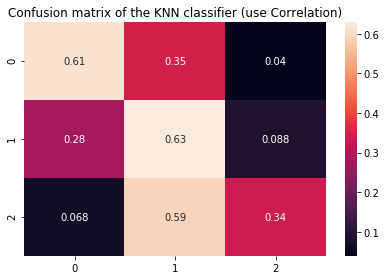

In [57]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate the accuracy of prediction
metrics = list()
cm = dict()

# Precision, recall, f-score from the multi-class support function
precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)

metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                          'fscore':fscore, 'accuracy':accuracy}, 
                         name='Model'))

metrics = pd.concat(metrics, axis=1)

print(metrics)

y_pred = knn.predict(X_test)
print(y_pred)

# Last, the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='.2g');
plt.title('Confusion matrix of the KNN classifier (use Correlation)')    
plt.tight_layout()

In [59]:
# another way to calculate the prediction accuracy by using a KNN built-in method
mean_accuracy = knn.score(X_test,y_test)
print(mean_accuracy)

0.5743392070484582


We will try now to get the quality prediction for a new wine that comes with the 5 sets of parameters:
'color', 'chlorides', 'volatile acidity', 'density', 'alcohol'

Examples:
    red wine:          [1,0.114,0.78,0.9545,8.5]
    white wine:        [0,0.032,0.23,0.9745,9.2]

In [88]:
X0 = [[1,0.114,0.78,0.9545,8.5],[0,0.032,0.23,0.9745,9.2]]
dfX=pd.DataFrame(X0)

print("===Wines (new data)=====================================================")
dfX.columns = ['color', 'chlorides', 'volatile acidity', 'density', 'alcohol']
dfX.index = ['red_wine_0','white_wine_0']
print(dfX)
print("\n===Predicted Quality====================================================")

inxs = dfX.index

dfX = scaler.transform(dfX)
y0_pred = knn.predict(dfX)
print("Predicted quality:")
print(f"{inxs[0]}:\t{y0_pred[0]}")
print(f"{inxs[1]}:\t{y0_pred[1]}")

===Wines (new data)=====================================================
              color  chlorides  volatile acidity  density  alcohol
red_wine_0        1      0.114              0.78   0.9545      8.5
white_wine_0      0      0.032              0.23   0.9745      9.2

===Predicted Quality====================================================
Predicted quality:
red_wine_0:	6
white_wine_0:	6
